In [2]:
# [1]: https://arxiv.org/pdf/1710.07313.pdf
# [2]: https://lib.uva.nl/discovery/fulldisplay?docid=aip_complete10.1063%2F1.4979665&context=PC&vid=31UKB_UAM1_INST:UVA&lang=en&search_scope=DN_and_CI_and_PURE&adaptor=Primo%20Central&tab=Everything&query=any,contains,Lu%20pathak%20hunt%20ott&offset=0

# Imports

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['text.usetex'] = True


import scipy
from scipy.integrate import RK45

from sklearn.linear_model import Ridge

import torch
import torch.nn as nn
import torch.optim as optim

# Generate the Data 
## The Lorenz and Rossler Systems

In [481]:
N_RELAXATION_STEPS = 5000
N_TRAINING_STEPS = 10000
N_TESTING_STEPS = 10000
DELTA_T = 0.02

In [472]:
def gen_lorenz_data(sigma=10., rho=28., beta=8./3, gamma = 0, n_steps=1000):

    def f(t, pos):
        x, y, z = pos
        return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z + gamma * x])
    
    init_state = np.random.uniform(size=3)*100

    integrand = RK45(f, 0, init_state, 10000, max_step=DELTA_T, vectorized=True)

    state = np.zeros([n_steps, 3])
    state[0, :] = init_state
    
    for t in range(1, n_steps):
        state[t, :] = np.array(integrand.y)
        integrand.step()
    
    return state

In [473]:
def gen_rossler_data(a=0.2, b=0.2, c=5, n_steps=1000):

    def f(t, pos):
        x, y, z = pos
        return np.array([-y-z, x  + a * y, b + z* (x-c)])
    
    init_state = np.random.uniform(size=3)

    integrand = RK45(f, 0, init_state, 10000, max_step=DELTA_T, vectorized=True)

    state = np.zeros([n_steps, 3])
    state[0, :] = init_state
    
    for t in range(1, n_steps):
        state[t, :] = np.array(integrand.y)
        integrand.step()
    
    return state

In [513]:
np.random.seed(123)
data_set = gen_lorenz_data(n_steps=N_TRAINING_STEPS + N_TESTING_STEPS + N_RELAXATION_STEPS)[N_RELAXATION_STEPS:] # Throw away the first

In [514]:
# Pre-processing - remove the mean and set the variance to 1
data_set -= np.mean(data_set, axis=0)
data_set /= np.std(data_set, axis=0)

In [515]:
training_set = data_set[:N_TRAINING_STEPS]
testing_set = data_set[N_TRAINING_STEPS:]

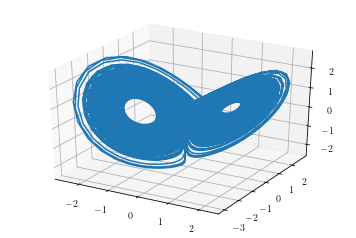

In [516]:
training_x, training_y, training_z = training_set[:, 0], training_set[:, 1], training_set[:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(training_x, training_y, training_z)

# The Reservoir Network

In [198]:
class ReservoirNetwork(object):
    def __init__(self, input_size, n_neurons, output_size, spectral_radius, average_degree=6, leakage_rate=1.0, bias=0., sigma=1.):
        super(ReservoirNetwork, self).__init__()

        self.input_size = input_size
        self.n_neurons = n_neurons
        self.output_size = output_size
        self.leakage_rate = leakage_rate
        self.bias = bias
        self.sigma = sigma
        
        self.reservoir_state = np.zeros(n_neurons) # Don't know how to initialize this
        self.adjacency_matrix = self.initialize_reservoir(n_neurons, spectral_radius, average_degree)
        self.input_matrix = self.initialize_input_matrix(n_neurons, input_size)
        self.output_matrix = np.zeros((n_neurons, output_size)) # extra term for the bias unit
        self.output_intercept = np.zeros(output_size)
        # right multiplied #np.random.uniform(size=(output_size, n_neurons))
    
    def update_reservoir_state(self, input_):
        
        if self.n_neurons == 1:
            #print('reshape', input_)
            input_ = np.array([input_])
                    
        input_contrib = np.dot(self.input_matrix, input_)
        
        if self.input_size == 1:
            input_contrib = (self.input_matrix * input_).reshape(self.n_neurons)
            
        #print(input_contrib.shape, self.adjacency_matrix.shape, self.reservoir_state.shape, np.dot(self.adjacency_matrix, self.reservoir_state).shape)
        
        self.reservoir_state = (1-self.leakage_rate) * self.reservoir_state + self.leakage_rate * np.tanh(np.dot(self.adjacency_matrix, self.reservoir_state) + input_contrib + self.bias)
        return self.reservoir_state
    
    def get_reservoir_state(self):
        return self.reservoir_state
    
    def get_output(self):
        tmp_reservoir = np.zeros(self.n_neurons)
        tmp_reservoir[:self.n_neurons] = self.reservoir_state
        
        return np.dot(self.output_matrix, tmp_reservoir) + self.output_intercept
    
    def forward(self, input_):
        self.update_reservoir_state(input_)

        #print("res: {}".format(self.reservoir_state.shape))
        #print("output: {}".format(self.output_matrix.shape))
        #modified_reservoir = self.reservoir_state
        #modified_reservoir[modified_reservoir.shape[0]//2:] =         modified_reservoir[modified_reservoir.shape[0]//2:]**2
        #return [
        #    np.dot(self.output_matrix[0, :], self.reservoir_state),
        #   np.dot(self.output_matrix[1, :], self.reservoir_state),
        #    np.dot(self.output_matrix[2, :], modified_reservoir),
        #]
        
        return self.get_output()
    
    def set_output_matrix(self, output_matrix, output_intercept=0):
        self.output_matrix = output_matrix
        self.output_intercept = output_intercept
        
    def initialize_input_matrix(self, n_neurons, input_size):
        """
        Each reservoir node receives input from exactly one input signal. 
        The non-zero elements are randomly chosen from uniform dist [-sigma, sigma]
        """
        #input_matrix = np.random.uniform(size=[n_neurons, input_size]) 
        #input_matrix = np.eye(n_neurons, input_size) 
        
        input_matrix = np.zeros([n_neurons, input_size]) 
        
        for i in range(n_neurons):
            input_idx = np.random.choice(np.arange(input_size)) 
            weight = (np.random.uniform() * 2 - 1) * self.sigma
            input_matrix[i, input_idx] = weight
            
        #print(input_matrix)
        
        return input_matrix

    @staticmethod
    def initialize_reservoir(n_neurons, spectral_radius, average_degree=6):
        """
        Initializes a sparse random Erdos-Renyi network and returns the adjacency matrix.

        Erdos-Renyi random network: https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model

        There are evidently two variants:
        1. Randomize edge presence/absence
        2. Randomize node pairs (We use this procedure)

        :param n_neurons: The number of neurons in the reservoir (int)
        :param spectral_radius: The value of the largest magnitude of the eigenvalues of A (float)
        :param average_degree: The average number of neurons adjacent to any given neuron (int, default=6)
        """

        assert average_degree <= n_neurons

        # Pick a pair of nodes randomly and add it if not already present
        # Repeat n times

        A = np.zeros((n_neurons, n_neurons))
        n_edges = 0

        while n_edges <= average_degree * n_neurons :
            node_1 = np.random.choice(np.arange(n_neurons))
            node_2 = np.random.choice(np.arange(n_neurons))

            if A[node_1, node_2] == 0:
                choice = np.random.uniform() * 2 - 1
                A[node_1, node_2] = choice
                A[node_2, node_1] = choice
                # This is an undirected graph so the adjacency matrix should be symmetric

                n_edges += 1

        largest_eigenvalue = np.sort(np.abs(np.linalg.eig(A)[0]))[-1]
        #print(np.linalg.eig(A * spectral_radius / largest_eigenvalue)[0]) 
        return A * spectral_radius / largest_eigenvalue
    
class LorenzReservoirNetwork(ReservoirNetwork):
    def __init__(self, n_neurons, spectral_radius, average_degree=6, leakage_rate=1.0, bias=0., sigma=1.):
        super(LorenzReservoirNetwork, self).__init__(3, n_neurons, 3, spectral_radius, average_degree, leakage_rate, bias, sigma)
    
    def get_reservoir_state(self, z2_symmetry=False):
        res = self.reservoir_state
        
        if z2_symmetry:
             res[self.n_neurons//2:] = np.square(res[self.n_neurons//2:])
                
        return res
    
    def get_output(self):
        res = np.zeros(3)
        
        res[:2] = np.dot(self.output_matrix[:2,:] , self.get_reservoir_state())
        res[2] = np.dot(self.output_matrix[2,:] , self.get_reservoir_state(z2_symmetry=True))
        
        return res + self.output_intercept
    
    
    

In [214]:
class ReservoirNetworkTrainer(object):
    def __init__(self, model):
        self.model = model
        
    def train(self, training_input, training_output, regularizer=1):
        """
        Minimizes  ( ||(P * r) - v_true||^2 + regularizer * ||P||^2 ) 
        averaged over the training set u, where 
        - r = r(u), the reservoir state given a training input,
        - v_true = the element of the training_v set corresponding to a given r(u)

        :param training_inputs: A collection of inputs for training (np.array with shape [n_training_examples, input_size])
        :param training_outputs: A collection of inputs for training (np.array with shape [n_training_examples, output_size])
        :param regularizer: A constant that discourages overfitting
        
        """
        # This is just a linear regression exercise
        #print("\n\nEpoch # {}".format(i))
        reservoir_states = np.zeros([training_input.shape[0], self.model.n_neurons])
        for i, input_ in enumerate(training_input):
            #print(input_, isinstance(input_, np.float64), input_.shape, self.model.reservoir_state.shape)
            reservoir_states[i, :] = self.model.update_reservoir_state(input_).reshape((1, -1))
                    
        clf = Ridge(alpha=regularizer)
        clf.fit(reservoir_states, training_output)
        self.model.set_output_matrix( clf.coef_, clf.intercept_)
            
        #print(self.model.output_matrix.shape, self.model.output_matrix[-1])            
        #print(self.model.output_matrix)
        
    def test(self, testing_set, n_input_steps=100, n_steps=500):
        
        results = np.zeros([n_steps, self.model.output_size])

        for i in range(0, n_input_steps):
            results[i, :] = self.model.forward(testing_set[i])
            

        for i in range(n_input_steps, n_steps):
            results[i, :] = self.model.forward(results[i-1])

        return results
        
        
class LorenzReservoirNetworkTrainer(ReservoirNetworkTrainer):
    def train(self, training_input, training_output, regularizer=1):
        """
        Minimizes  ( ||(P * r) - v_true||^2 + regularizer * ||P||^2 ) 
        averaged over the training set u, where 
        - r = r(u), the reservoir state given a training input,
        - v_true = the element of the training_v set corresponding to a given r(u)

        :param training_inputs: A collection of inputs for training (np.array with shape [n_training_examples, input_size])
        :param training_outputs: A collection of inputs for training (np.array with shape [n_training_examples, output_size])
        :param regularizer: A constant that discourages overfitting
        
        """
        # This is just a linear regression exercise
        #print("\n\nEpoch # {}".format(i))
        reservoir_states = np.zeros([training_input.shape[0], self.model.n_neurons])
        z2_reservoir_states = np.zeros([training_input.shape[0], self.model.n_neurons])
        for i, input_ in enumerate(training_input):
            #print(input_, isinsstance(input_, np.float64), input_.shape, self.model.reservoir_state.shape)
            reservoir_states[i, :] = self.model.update_reservoir_state(input_).reshape((1, -1))
            z2_reservoir_states[i, :] = self.model.get_reservoir_state(z2_symmetry=True).reshape((1, -1))
                    
        output_matrix = np.zeros((self.model.output_size, self.model.n_neurons))
        output_intercept = np.zeros(self.model.output_size)

        clf1 = Ridge(alpha=regularizer)
        clf1.fit(reservoir_states, training_output[:, :2])
        output_matrix[:2, :] = clf1.coef_
        output_intercept[:2] = clf1.intercept_
                        
        clf2 = Ridge(alpha=regularizer)
        clf2.fit(z2_reservoir_states, training_output[:, 2])
        output_matrix[2, :] = clf2.coef_
        output_intercept[2] = clf2.intercept_
        
        #print(output_matrix)
        #print(reservoir_states[:10, :])
        #print(z2_reservoir_states[:10, :])

        self.model.set_output_matrix(output_matrix, output_intercept)


# Training and Testing

# Plotting

Text(0.5,0,'$z$')

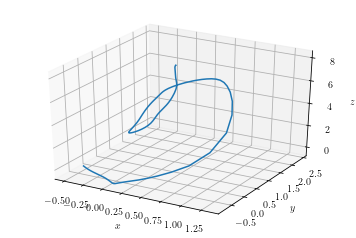

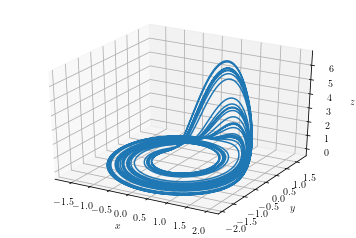

In [503]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(3, 1000, 3, 1.7, 6, sigma=1)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:-1], training_set[1:], 0.0001)
predicted_set = reservoir_trainer.test(testing_set, n_steps=N_TESTING_STEPS)

predicted_x, predicted_y, predicted_z = predicted_set[100:, 0], predicted_set[100:, 1], predicted_set[100:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(predicted_x, predicted_y, predicted_z)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

testing_x, testing_y, testing_z = testing_set[100:, 0], testing_set[100:, 1], testing_set[100:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(testing_x, testing_y, testing_z)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

Text(0.5,0,'$z$')

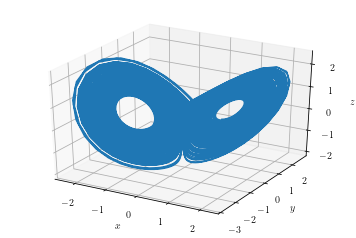

In [520]:
np.random.seed(123)
reservoir_network = LorenzReservoirNetwork(1000, 1.4, 10, sigma=1)
reservoir_trainer = LorenzReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:-1], training_set[1:], 0.0001)
predicted_set = reservoir_trainer.test(testing_set, n_steps=100000)

"""
predicted_x, predicted_y, predicted_z = predicted_set[100:, 0], predicted_set[100:, 1], predicted_set[100:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(predicted_x, predicted_y, predicted_z)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
"""

testing_x, testing_y, testing_z = testing_set[100:, 0], testing_set[100:, 1], testing_set[100:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(testing_x, testing_y, testing_z)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

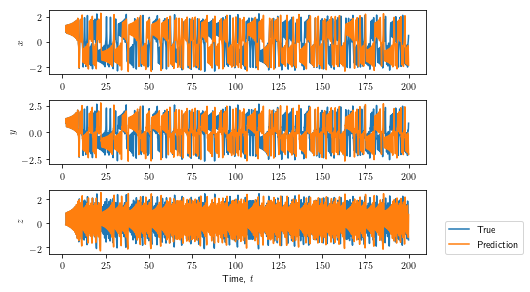

In [518]:
times = np.arange(100, N_TESTING_STEPS)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(times * DELTA_T, testing_x, times * DELTA_T, predicted_x)
ax1.set_ylabel(r'$x$')
ax2.plot(times * DELTA_T, testing_y, times * DELTA_T, predicted_y)
ax2.set_ylabel(r'$y$')
ax3.plot(times * DELTA_T, testing_z,)
ax3.plot(times * DELTA_T, predicted_z)
ax3.set_ylabel(r'$z$')
ax3.set_xlabel(r'Time, $t$')

plt.tight_layout(pad=0.5)
plt.legend(["True", "Prediction"],bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)



Text(0,0.5,'\\huge{$z_{i+1}$}')

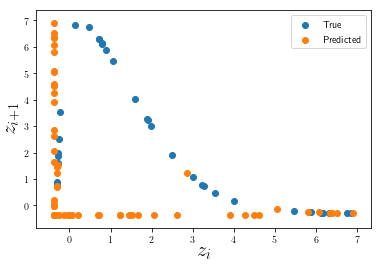

In [506]:
from scipy.signal import argrelextrema

pred_z_maxes = predicted_z[argrelextrema(predicted_z, np.greater)]
testing_z_maxes = testing_z[argrelextrema(testing_z, np.greater)]


plt.scatter(testing_z_maxes[:-1], testing_z_maxes[1:], label=r'True')
plt.scatter(pred_z_maxes[:-1], pred_z_maxes[1:], label=r'Predicted')
plt.legend()
plt.xlabel(r'\huge{$z_i$}')
plt.ylabel(r'\huge{$z_{i+1}$}')

# Predict Y when given X

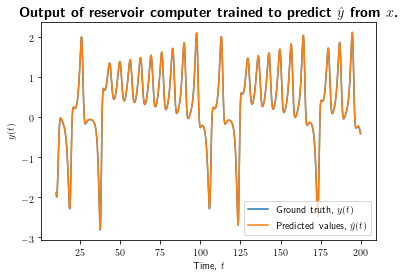

In [78]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 1000, 1, 1.2, 20)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:, 0], training_set[:, 1], .0001)
predicted_set_y = reservoir_trainer.test(testing_set[:, 0], N_TESTING_STEPS, N_TESTING_STEPS)[100:]

times = np.arange(100, N_TESTING_STEPS)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times * DELTA_T, testing_y, label='Ground truth, $y(t)$')
ax1.plot(times * DELTA_T, predicted_set_y[:,0], label='Predicted values, $\hat{y}(t)$')
plt.title(r'\Large{\textbf{Output of reservoir computer trained to predict $\hat y$ from $x$.}}')
plt.xlabel('Time, $t$')
plt.ylabel('$y(t)$')
plt.legend()


# Predict X given Y

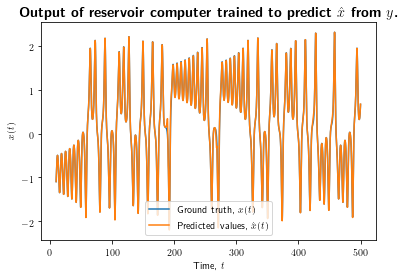

In [331]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 1000, 1, 1.2, 6)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:, 1], training_set[:, 0], .0001)
predicted_set_x = reservoir_trainer.test(testing_set[:, 1], N_TESTING_STEPS, N_TESTING_STEPS)[100:]

times = np.arange(100, N_TESTING_STEPS)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times * DELTA_T, testing_x, label='Ground truth, $x(t)$')
ax1.plot(times * DELTA_T, predicted_set_x[:,0], label='Predicted values, $\hat{x}(t)$')
plt.title(r'\Large{\textbf{Output of reservoir computer trained to predict $\hat x$ from $y$.}}')
plt.xlabel('Time, $t$')
plt.ylabel('$x(t)$')
plt.legend()


# Predict Z given X

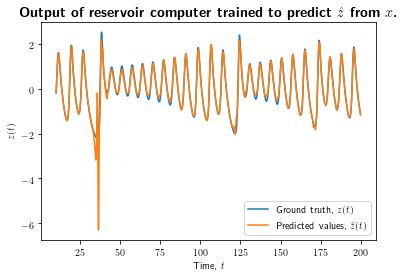

In [215]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 1000, 1, 1.2, 20)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:, 0:1], training_set[:, 2], .00001)
predicted_set_z = reservoir_trainer.test(testing_set[:, 0:1], N_TESTING_STEPS, N_TESTING_STEPS)[100:]

times = np.arange(100, N_TESTING_STEPS)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times * DELTA_T, testing_z, label='Ground truth, $z(t)$')
ax1.plot(times * DELTA_T, predicted_set_z[:,0], label='Predicted values, $\hat{z}(t)$')
plt.title(r'\Large{\textbf{Output of reservoir computer trained to predict $\hat z$ from $x$.}}')
plt.xlabel('Time, $t$')
plt.ylabel('$z(t)$')
plt.legend()

In [1]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 100, 1, 1.2, 20)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:-1, 0], training_set[1:, 0], .0001)
predicted_set_delay = reservoir_trainer.test(testing_set[:, 0], 300, N_TESTING_STEPS)

times = np.arange(N_TESTING_STEPS-1)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times, testing_x[1:], times, predicted_set_delay[:-1])


NameError: name 'np' is not defined

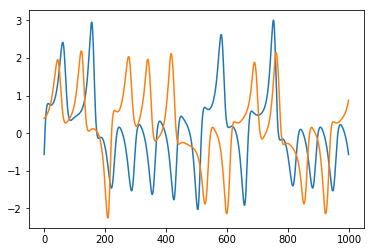

In [706]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 1000, 1, 1, 20)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:-1, 1], training_set[1:, 1], .1)
predicted_set_delay = reservoir_trainer.test(testing_set[:, 1], 300, N_TESTING_STEPS)

times = np.arange(N_TESTING_STEPS-1)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times, testing_y[1:], times, predicted_set_delay[:-1])


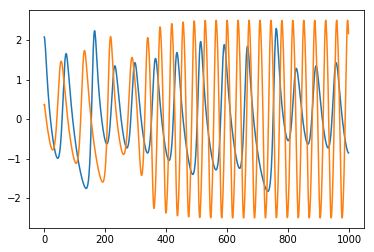

In [708]:
np.random.seed(123)
reservoir_network = ReservoirNetwork(1, 1000, 1, 1., 20)
reservoir_trainer = ReservoirNetworkTrainer(reservoir_network)
reservoir_trainer.train(training_set[:-1, 2], training_set[1:, 2], .0001)
predicted_set_delay = reservoir_trainer.test(testing_set[:, 2], 300, N_TESTING_STEPS)

times = np.arange(N_TESTING_STEPS-1)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(times, testing_z[1:], times, predicted_set_delay[:-1])

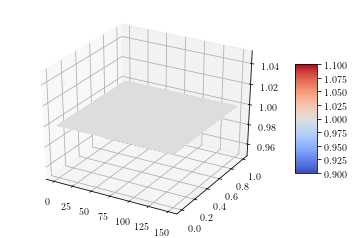

In [512]:

from matplotlib import cm

# KSequ.m - solution of Kuramoto-Sivashinsky equation
#
# u_t = -u*u_x - u_xx - u_xxxx, periodic boundary conditions on [0,32*pi]
# computation is based on v = fft(u), so linear term is diagonal
#
# Using this program:
# u is the initial condition
# h is the time step
# N is the number of points calculated along x
# a is the max value in the initial condition
# b is the min value in the initial condition
# x is used when using a periodic boundary condition, to set up in terms of
#   pi
#
# Initial condition and grid setup
N = 1024
x = np.transpose(np.conj(np.arange(1, N+1))) / N
a = -1
b = 1
u = np.cos(x/16)*(1+np.sin(x/16))
v = np.fft.fft(u)
# scalars for ETDRK4
h = 0.25
k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))))) / 16
L = k**2 - k**4
E = np.exp(h*L)
E_2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
# main loop
uu = np.array([u])
tt = 0
tmax = 150
nmax = int(round(tmax/h))
nplt = int((tmax/100)/h)
g = -0.5j*k
for n in range(1, nmax+1):
    t = n*h
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E_2*v + Q*Nv
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E_2*v + Q*Na
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E_2*a + Q*(2*Nb-Nv)
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
tt, x = np.meshgrid(tt, x)
surf = ax.plot_surface(tt, x, uu.transpose(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()